In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('TweetSentiment').getOrCreate()

In [2]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression

In [3]:
df = spark.read.csv('../Datasets/Sentiment140.csv', inferSchema=True, header=False)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
table_schema = StructType([
    StructField("sentiment", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])
df = spark.read.csv('../Datasets/Sentiment140.csv', inferSchema=False, header=False, schema=table_schema)
df.printSchema()

root
 |-- sentiment: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [5]:
df = df.drop(*['id', 'date', 'flag', 'user'])

In [6]:
df.show(10)

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        0|@switchfoot http:...|
|        0|is upset that he ...|
|        0|@Kenichan I dived...|
|        0|my whole body fee...|
|        0|@nationwideclass ...|
|        0|@Kwesidei not the...|
|        0|         Need a hug |
|        0|@LOLTrish hey  lo...|
|        0|@Tatiana_K nope t...|
|        0|@twittera que me ...|
+---------+--------------------+
only showing top 10 rows



In [7]:
# Number of missing values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---------+----+
|sentiment|text|
+---------+----+
|        0|   0|
+---------+----+



In [8]:
# How many values in the class? show them
from pyspark.sql.functions import col, countDistinct
df.agg(countDistinct(col("sentiment")).alias("sentiment")).show()
df.select('sentiment').distinct().collect()

+---------+
|sentiment|
+---------+
|        2|
+---------+



[Row(sentiment=4), Row(sentiment=0)]

In [9]:
df.createOrReplaceTempView('tweets')

In [10]:
spark.sql('select count(*) as zeros from tweets where sentiment = 0').show()
spark.sql('select count(*) as fours from tweets where sentiment = 4').show()

+------+
| zeros|
+------+
|800000|
+------+

+------+
| fours|
+------+
|800000|
+------+



In [11]:
(df_train, df_test) = df.randomSplit([0.9, 0.1], seed = 2)

#### RegexTokenizer: 
More advanced version of Tokenizer that allows regular expressions
#### CountVectorizer: 
converts a collection of text documents (rows) to vectors of token counts (count of each word in the sample) which is stored in a dictionary like {word1_index: 1, word2_index: 3, word3_index: 1}
#### IDF: 
Reduces the effect of popular words since they usually carry little information about the document like “a”, “the”


In [12]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
import datetime
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+")
cv = CountVectorizer(vocabSize=2**14, inputCol=tokenizer.getOutputCol(), outputCol='cv')
idf = IDF(inputCol=cv.getOutputCol(), outputCol="features", minDocFreq=3)
prepare_label = StringIndexer(inputCol = "sentiment", outputCol = "label")
#model = LogisticRegression(maxIter=100, regParam=0.01, elasticNetParam=0.0)
model = LinearSVC(maxIter=10, regParam=0.0)
#model = NaiveBayes(smoothing=1.0)
#model = RandomForestClassifier(numTrees=100)

before_training = datetime.datetime.now()

pipeline = Pipeline(stages=[tokenizer, cv, idf, prepare_label, model])
pipe_fit = pipeline.fit(df_train)
df_train2 = pipe_fit.transform(df_train)

elapsed = datetime.datetime.now() - before_training
print('Training time:', elapsed.total_seconds())

Training time: 69.3951


In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
df_test2 = pipe_fit.transform(df_test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(df_test2)

0.8683574807371182

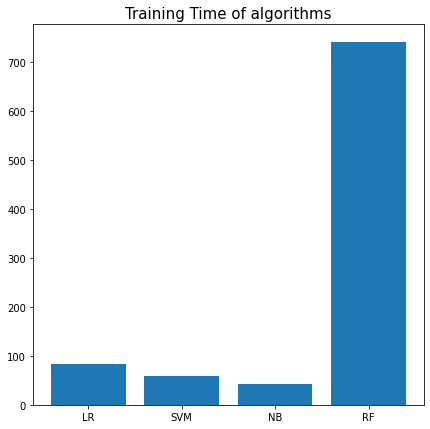

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(7, 7))
plt.title('Training Time of algorithms', size=15)
df_time = pd.DataFrame([['LR', 83], ['SVM', 58], ['NB', 42], ['RF', 740]], columns=['Algorithm', 'TrainingTime'])
plt.bar(df_time.Algorithm, df_time.TrainingTime)
plt.show()

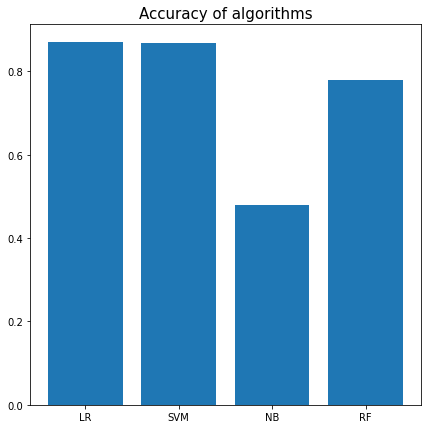

In [15]:
plt.figure(figsize=(7, 7))
plt.title('Accuracy of algorithms', size=15)
df_accuracy = pd.DataFrame([['LR', .869], ['SVM', .868], ['NB', .480], ['RF', .778]], columns=['Algorithm', 'Accuracy'])
plt.bar(df_accuracy.Algorithm, df_accuracy.Accuracy)
plt.show()

# Results:
#### Accuracy: 
LogisticRegression and LinearSVC achieved the highest accuracy, 87%
#### Training time: 
The least training time of 42 seconds was achieved by Naive Bayes, and the highest was reached by Random forest (740 seconds). LinearSVC was trained in 58 seconds, and LogisticRegression in 83.
#### Deployment: 
The extremely low accuracy of Naive Bayes makes it useless, and the high training time of random forest makes it costly to train, and considering that its accuracy is lower than that of Logistic regression and Linear SVC, it will not be considered for deployment. The clear choices are either Linear SVC or Logistic regression.